In [ ]:
# advance neuro project

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import torch
import pandas as pd

In [40]:
# select the device to run the code on
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

In [41]:
def ReLU(x):
    zeros_mat = torch.zeros(x.shape, device=dev)
    output = torch.fmax(x, zeros_mat)
    return output

In [42]:
def ReLU_deriv(x):
    non_negs = torch.where(x >= 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1
    return output

In [43]:
def angleCal(A, B):
    num = torch.trace(torch.matmul(torch.conj(A.T), B))
    norm_A = math.sqrt(torch.trace(torch.matmul(A,torch.conj(A.T))))
    norm_B = math.sqrt(torch.trace(torch.matmul(B,torch.conj(B.T))))
    denum = norm_A*norm_B
    angle = torch.arccos(num/denum)*180/math.pi
    return angle

In [44]:
def forb_norm(A):
  norm = torch.sqrt(torch.sum(torch.pow(A,2)))
  return norm

In [ ]:
#### network parameters - open loop 2 layer network - first condition - auto correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles1 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)
    
    # input layer values - # move on gpu
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    
    for j in range (number_of_iterations):
        angles1[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


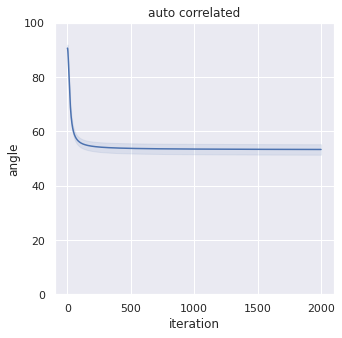

In [ ]:
## plot the result of auto correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5));
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0));
ax.set_ylim([0, 100]);
ax.set_title('auto correlated');
ax.set_ylabel('angle');
ax.set_xlabel('iteration');
ax.grid(True);

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [ ]:
#### network parameters - open loop 2 layer network - second condition - cross correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles2 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.clone(input_layer) # cross correlated with inputs of network
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
    
    for j in range (number_of_iterations):
        angles2[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = torch.clone(error_delta2)
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.clone(input_layer)
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


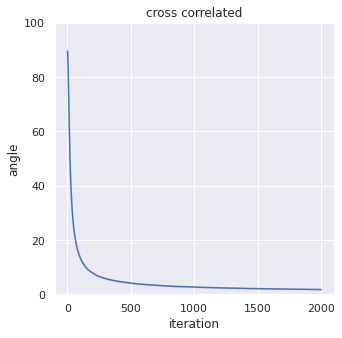

In [ ]:
# plot the result of cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [ ]:
#### network parameters - open loop 2 layer network - third condition - not auto correlated nor cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles3 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta1 = torch.matmul(error_delta2, backward_weight_1)

    for j in range (number_of_iterations):
        angles3[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(forward_weight_0.T, input_layer.T).T
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) 
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


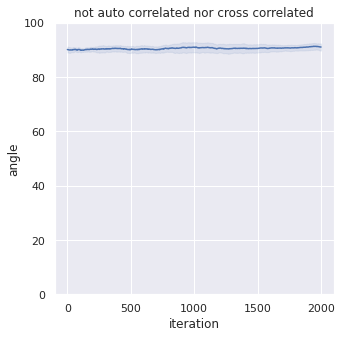

In [ ]:
# plot the result of not auto correlated nor cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('not auto correlated nor cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [ ]:
#### network parameters - open loop 2 layer network - forth condition - auto correlated & cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles4 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = input_layer # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    # delta 2 doesn't change

    for j in range (number_of_iterations):
        angles4[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


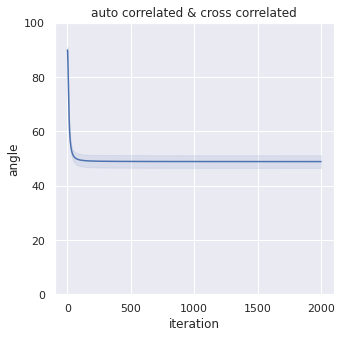

In [ ]:
# plot the result of auto correlated & cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('auto correlated & cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


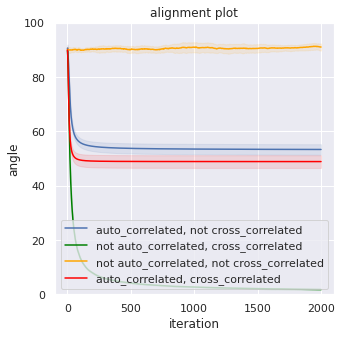

In [ ]:
# plot the result of all three conditions together

    
fig, ax = plt.subplots(1,1,figsize=(5,5))

# condition 1
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence1 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);

# condition 2
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0),color='green')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence2 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='green', alpha=.1);

# condition 3
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0),color='orange')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence3 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='orange', alpha=.1);

# condition 4
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0),color='red')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence4 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='red', alpha=.1);

ax.legend(['auto_correlated, not cross_correlated','not auto_correlated, cross_correlated',\
           'not auto_correlated, not cross_correlated',\
          'auto_correlated, cross_correlated'],loc='lower right')

In [ ]:
# Paper Part - 2.3 Using the provided theoretical tool to investigate FA in the learning process of a practical deep ANN
# train and test a 5 layer network on MNIST
# fact = tanh(ReLU) - 50 neurons in all hidden and output layer - output layer is using 5 hot coding
# images of MNIST should be resized to 15*15 - so we have 225 neurons in input layer 
# inputs should be normalized 
# batch size = 1000, 60 batches available (total numbre of 60K images)
# initialization of forward/ backward weights and biases is done using N(0,0.1)
# loss function is sth like squared error, check page 5 for the details

In [45]:
def n_hot_coder(x,n,hot_labels,output_neuron_num):
    labels = x.cpu().numpy()
    category_num = 10
    if(category_num*n > output_neuron_num):
        print('nhot encoding can`t be done since the condition`s not met')
        return False
    
    output = torch.zeros((len(x),output_neuron_num), device=dev)
    
    output[np.where(labels == 0),:] = hot_labels[0,:]
    output[np.where(labels == 1),:] = hot_labels[1,:]
    output[np.where(labels == 2),:] = hot_labels[2,:]
    output[np.where(labels == 3),:] = hot_labels[3,:]
    output[np.where(labels == 4),:] = hot_labels[4,:]
    output[np.where(labels == 5),:] = hot_labels[5,:]
    output[np.where(labels == 6),:] = hot_labels[6,:]
    output[np.where(labels == 7),:] = hot_labels[7,:]
    output[np.where(labels == 8),:] = hot_labels[8,:]
    output[np.where(labels == 9),:] = hot_labels[9,:]

    return output

In [46]:
def loss_function(output_layer,labels):
    difference = labels-output_layer
    output = 0.5*(torch.sum(difference**2))
    return output

In [47]:
def tanh_Relu_deriv(x):
    non_negs = torch.where(x > 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1-torch.tanh(x[non_negs])**2
    return output

In [48]:
def binarize_output(output,n,categories_nhot):
  
    binarized = torch.zeros((output.shape[0],output.shape[1]), device=dev)
    current_data_scores = torch.matmul(output,categories_nhot.T)
    _, closest_label = torch.max(current_data_scores,dim=1)
    binarized = categories_nhot[closest_label,:]
    
    return binarized

In [49]:
def accuracy_cal(output,label):
    acc = 0
    
    compare = output.shape[1]*torch.ones((output.shape[0]), device=dev)
    acc = torch.sum(torch.eq(torch.sum(torch.eq(output,label),dim=1),compare))
  
    acc = acc/len(output)*100 # in percentage
    return acc

In [50]:
def alignment_term_cal(iter_needed,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime,delta4_inTime,delta3_inTime,\
                      delta2_inTime,input_layer,hidden_layer1_inTime,hidden_layer2_inTime,\
                      hidden_layer3_inTime,hidden_layer4_inTime,output_layer_size):

    alignment_terms = [];
    
    
    # cal alignment terms
    for i in range(1,iter_needed): # iteration
      if(i == 65 or i == 1259): # for fig 2
          print(i)
          o = 0
          torch.cuda.empty_cache()
          alignment_terms_k = torch.zeros((i,layer_num,output_layer_size,output_layer_size), device=dev)
          while (o < i):
              # l1
              alignment_terms_k[o,0,:,:] = (LR**2)*torch.chain_matmul(B1.T,delta2_inTime[i-o-1,:,:].T,\
                                                                      input_layer[np.mod(i-o-1,batch_num),:,:],input_layer[np.mod(i,batch_num),:,:].T,\
                                                                      delta2_inTime[i,:,:])
              # l2
              alignment_terms_k[o,1,:,:] = (LR**2)*torch.chain_matmul(B2.T,delta3_inTime[i-o-1,:,:].T,\
                                                                      hidden_layer1_inTime[i-o-1,:,:],hidden_layer1_inTime[i,:,:].T,\
                                                                      delta3_inTime[i,:,:])
              # l3
              alignment_terms_k[o,2,:,:] = (LR**2)*torch.chain_matmul(B3.T,delta4_inTime[i-o-1,:,:].T,\
                                                                      hidden_layer2_inTime[i-o-1,:,:],hidden_layer2_inTime[i,:,:].T,\
                                                                      delta4_inTime[i,:,:])
              # l4
              alignment_terms_k[o,3,:,:] = (LR**2)*torch.chain_matmul(B4.T,delta5_inTime[i-o-1,:,:].T,\
                                                                hidden_layer3_inTime[i-o-1,:,:],hidden_layer3_inTime[i,:,:].T,\
                                                                delta5_inTime[i,:,:])
              
              o += 1
          
          alignment_terms.append(alignment_terms_k)
        
    return alignment_terms

In [51]:
def create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                   hidden_layer3_size,hidden_layer4_size,output_layer_size):

  # forward weights
  w0 = torch.normal(mu,sigma,size=(input_layer_size,hidden_layer1_size), device=dev)
  w1 = torch.normal(mu,sigma,size=(hidden_layer1_size,hidden_layer2_size), device=dev)
  w2 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer3_size), device=dev)
  w3 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer4_size), device=dev)
  w4 = torch.normal(mu,sigma,size=(hidden_layer4_size,output_layer_size), device=dev)

  # backward weights
  B4 = torch.normal(mu,sigma,size=(output_layer_size,hidden_layer4_size), device=dev)
  B3 = torch.normal(mu,sigma,size=(hidden_layer4_size,hidden_layer3_size), device=dev)
  B2 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer2_size), device=dev)
  B1 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer1_size), device=dev)

  # bias vectors
  b1 =  torch.normal(mu,sigma,size=(1,hidden_layer1_size), device=dev)
  b2 =  torch.normal(mu,sigma,size=(1,hidden_layer2_size), device=dev)
  b3 =  torch.normal(mu,sigma,size=(1,hidden_layer3_size), device=dev)
  b4 =  torch.normal(mu,sigma,size=(1,hidden_layer4_size), device=dev)
  b5 =  torch.normal(mu,sigma,size=(1,output_layer_size), device=dev)

  print('network parameters created!')

  return w0, w1, w2, w3, w4, B4, B3, B2, B1, b1, b2, b3, b4, b5


In [52]:
def shuffle(arr, percentage):

  arr_shuffled = np.copy(arr)

  ix_size = int(percentage * len(arr))
  ix = np.random.choice(len(arr), size=ix_size, replace=False)
  b = arr[ix]
  np.random.shuffle(b)
  arr_shuffled[ix] = b

  return arr_shuffled

In [53]:
def moving_avg(arr, window_size):

  numbers_series = pd.Series(arr)
    
  windows = numbers_series.rolling(window_size)
    
  moving_averages = windows.mean()
  moving_averages_list = moving_averages.tolist()
    
  # Remove null entries from the list
  final_list = moving_averages_list[window_size - 1:]

  return final_list

In [79]:
def loss_val_testdata(w0,w1,w2,w3,w4,b1,b2,b3,b4,b5,categories_nhot,y_test_nhot,x_te_norm):

  # accuracy on test data - dont run if running other next parts pls

  batch_size = 1
  batch_num = int(x_te_norm.shape[0]/batch_size)
  im_size = 15*15
  input_layer = x_te_norm.reshape((batch_num,batch_size,im_size))
  loss_training = torch.zeros((batch_num), device=dev)
  accuracy_training = torch.zeros((batch_num), device=dev)


  for i in range(batch_num):
      # forward
      z1 = torch.matmul(input_layer[i,:,:],w0) + b1
      hidden_layer1 = torch.tanh(ReLU(z1))
      z2 = torch.matmul(hidden_layer1,w1) + b2
      hidden_layer2 = torch.tanh(ReLU(z2))
      z3 = torch.matmul(hidden_layer2,w2) + b3
      hidden_layer3 = torch.tanh(ReLU(z3))
      z4 = torch.matmul(hidden_layer3,w3) + b4
      hidden_layer4 = torch.tanh(ReLU(z4))
      z5 = torch.matmul(hidden_layer4,w4) + b5
      output_layer = torch.tanh(ReLU(z5))

      # binarize output
      n = 5
      output_layer_binarized = binarize_output(output_layer,n,categories_nhot)
      
      # loss val and accuracy
      loss_training[i] = loss_function(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:])
      accuracy_training[i] = accuracy_cal(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:])



  print('accuracy: ',torch.mean(accuracy_training),' | loss value: ', torch.mean(loss_training))

  return torch.mean(accuracy_training), torch.mean(loss_training)

In [55]:
# Load MNIST Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# shuffle labels for fig6 - uncomment for result of shuffled labels
# random.shuffle(y_train)

# convert images to pytorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)


print('data loaded!')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


data loaded!
torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])


In [56]:
# resize images to 15*15
from torchvision import transforms as trans
import torchvision.transforms.functional as Func

x_train_resized = torch.zeros((x_train.shape[0],15,15))
x_test_resized = torch.zeros((x_test.shape[0],15,15))
resize_trans = trans.Resize(15)

# resize train images
for i in range (x_train.shape[0]):
    image = x_train[i,:,:].unsqueeze(0)
    x_train_resized[i,:,:] = resize_trans(image)

    
# resize test images
for i in range (x_test.shape[0]):
    image = x_test[i,:,:].unsqueeze(0)
    x_test_resized[i,:,:] = resize_trans(image)
    
print('resizing done!')
print(x_train_resized.shape,x_test_resized.shape)


resizing done!
torch.Size([60000, 15, 15]) torch.Size([10000, 15, 15])


In [57]:
# convert images and labels to pytorch tensors & vectorize them

x_train_flat = x_train_resized.reshape(x_train_resized.shape[0],-1)
x_test_flat = x_test_resized.reshape(x_test_resized.shape[0],-1)

x_train_flat = x_train_flat.to(dev)
x_test_flat = x_test_flat.to(dev)
y_train = y_train.to(dev)
y_test = y_test.to(dev)

print('vectorization done!')
print(x_train_flat.shape,x_test_flat.shape)

vectorization done!
torch.Size([60000, 225]) torch.Size([10000, 225])


In [58]:
# normalize images

x_tr_norm = x_train_flat/255
x_te_norm  = x_test_flat/255


print('normalization done!')

normalization done!


In [59]:
# n hot coding the labels
category_num = 10
output_neuron_num = 50
n = int(output_neuron_num/category_num)

# encoding the categroies
categories_nhot = torch.zeros((category_num,output_neuron_num), device=dev)
codes = torch.randperm(output_neuron_num, device=dev)

for i in range(category_num):
    categories_nhot[i,codes[i*n:(i+1)*n]] = 1 
    
y_train_nhot = n_hot_coder(y_train,n,categories_nhot,output_neuron_num)
y_test_nhot = n_hot_coder(y_test,n,categories_nhot,output_neuron_num)

print('n hot coding done!')
print(y_train_nhot.shape, y_test_nhot.shape)


n hot coding done!
torch.Size([60000, 50]) torch.Size([10000, 50])


In [60]:
# network params
mu = 0
sigma = 0.1

# each layer size
input_layer_size = 225
hidden_layer1_size = 50
hidden_layer2_size = 50
hidden_layer3_size = 50
hidden_layer4_size = 50
output_layer_size = 50


In [23]:
######################################## learning with feedback alignment
import pandas as pd
import gc

gc.collect()
# run the network - calculate alignment terms and angles between B and W simultaneously

LR = 0.0005
batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
epoch_num = 100
run_num = 10


accuracy_training = torch.zeros((run_num,batch_num,epoch_num), device=dev)
loss_training = torch.zeros((run_num,batch_num,epoch_num), device=dev)

# angle between B & W - for fig 7B - NO WN
alignment = torch.zeros((run_num,4,batch_num*epoch_num), device=dev)


# alignment between alignment terms & B
alignment_terms = []
angles_alignment_terms = np.zeros((run_num,2,65,layer_num)) # fig 2

# just for fig 7A - uncomment if needed
w0_wk = torch.zeros((run_num,5,batch_num*epoch_num), device=dev)


# angle between delta W FA and BP - for fig 7E
alignment_dw_fa_B = torch.zeros((run_num,4,batch_num*epoch_num), device=dev)

for k in range(run_num):
  print('run ', k, ' ...')

  # create network parameters
  w0, w1, w2, w3, w4, B4, B3, B2, B1, b1, b2, b3, b4, b5 = \
  create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                    hidden_layer3_size,hidden_layer4_size,output_layer_size)
  
  
  # layer and delta values in iterations for calculating alignment terms - fig2 
  iter_needed = 1260
  # hidden_layer1_inTime = torch.zeros((iter_needed,batch_size,hidden_layer1_size), device=dev)
  # hidden_layer2_inTime = torch.zeros((iter_needed,batch_size,hidden_layer2_size), device=dev)
  # hidden_layer3_inTime = torch.zeros((iter_needed,batch_size,hidden_layer3_size), device=dev)
  # hidden_layer4_inTime = torch.zeros((iter_needed,batch_size,hidden_layer4_size), device=dev)
  # delta5_inTime = torch.zeros((iter_needed,batch_size,output_layer_size), device=dev)
  # delta4_inTime = torch.zeros((iter_needed,batch_size,hidden_layer4_size), device=dev)
  # delta3_inTime = torch.zeros((iter_needed,batch_size,hidden_layer3_size), device=dev)
  # delta2_inTime = torch.zeros((iter_needed,batch_size,hidden_layer2_size), device=dev)

  # just for fig 7A - uncomment if needed
  # w0_0 = torch.clone(w0)

  # w1_0 = torch.clone(w1)
  # w2_0 = torch.clone(w2)
  # w3_0 = torch.clone(w3)
  # w4_0 = torch.clone(w4)


  for j in range(epoch_num):

      order = torch.arange(0,batch_num+1) # not shuffled

      # shuffling - fig 2 shuffling plot - uncomment for just shuffled order data
      # order = torch.randperm(batch_num, device=dev) # shuffled

      for i in range(batch_num):

          # wk norm to w0 norm - fig 7A - uncomment if needed
          # w0_wk[k,0,j*batch_num+i] = forb_norm(w0)/forb_norm(w0_0)
          # w0_wk[k,1,j*batch_num+i] = forb_norm(w1)/forb_norm(w1_0)
          # w0_wk[k,2,j*batch_num+i] = forb_norm(w2)/forb_norm(w2_0)
          # w0_wk[k,3,j*batch_num+i] = forb_norm(w3)/forb_norm(w3_0)
          # w0_wk[k,4,j*batch_num+i] = forb_norm(w4)/forb_norm(w4_0)


          # forward
          z1 = torch.matmul(input_layer[order[i],:,:],w0) + b1
          hidden_layer1 = torch.tanh(ReLU(z1))
          z2 = torch.matmul(hidden_layer1,w1) + b2
          hidden_layer2 = torch.tanh(ReLU(z2))
          z3 = torch.matmul(hidden_layer2,w2) + b3
          hidden_layer3 = torch.tanh(ReLU(z3))
          z4 = torch.matmul(hidden_layer3,w3) + b4
          hidden_layer4 = torch.tanh(ReLU(z4))
          z5 = torch.matmul(hidden_layer4,w4) + b5
          output_layer = torch.tanh(ReLU(z5))
          
          # backward the error
          E = y_train_nhot[order[i]*batch_size:(order[i]+1)*batch_size,:]-output_layer
          delta5 = torch.multiply(E,tanh_Relu_deriv(z5))
          delta4 = torch.multiply(torch.matmul(delta5,B4),tanh_Relu_deriv(z4))
          delta3 = torch.multiply(torch.matmul(delta4,B3),tanh_Relu_deriv(z3))
          delta2 = torch.multiply(torch.matmul(delta3,B2),tanh_Relu_deriv(z2))
          delta1 = torch.multiply(torch.matmul(delta2,B1),tanh_Relu_deriv(z1))
          
          # save values in time for calculating alignment terms - just up to iteration 1260
          # if(j*batch_num+i < iter_needed):
          #     hidden_layer1_inTime[j*batch_num+i,:,:] = hidden_layer1
          #     hidden_layer2_inTime[j*batch_num+i,:,:] = hidden_layer2
          #     hidden_layer3_inTime[j*batch_num+i,:,:] = hidden_layer3
          #     hidden_layer4_inTime[j*batch_num+i,:,:] = hidden_layer4
          #     delta5_inTime[j*batch_num+i,:,:] = delta5
          #     delta4_inTime[j*batch_num+i,:,:] = delta4
          #     delta3_inTime[j*batch_num+i,:,:] = delta3
          #     delta2_inTime[j*batch_num+i,:,:] = delta2
          
          
          # update forward weights 
          w4 += LR*torch.matmul(hidden_layer4.T,delta5)
          w3 += LR*torch.matmul(hidden_layer3.T,delta4)
          w2 += LR*torch.matmul(hidden_layer2.T,delta3)
          w1 += LR*torch.matmul(hidden_layer1.T,delta2)
          w0 += LR*torch.matmul(input_layer[order[i],:,:].T,delta1)
          
          # update biases
          J = torch.ones((1,batch_size), device=dev)
          b5 += torch.squeeze(LR*torch.matmul(J,delta5))
          b4 += torch.squeeze(LR*torch.matmul(J,delta4))
          b3 += torch.squeeze(LR*torch.matmul(J,delta3))
          b2 += torch.squeeze(LR*torch.matmul(J,delta2))
          b1 += torch.squeeze(LR*torch.matmul(J,delta1))
          
          # binarize output
          n = 5 # n hot
          output_layer_binarized = binarize_output(output_layer,n,categories_nhot)

          # loss values
          loss_training[k,i,j] = loss_function(output_layer,y_train_nhot[order[i]*batch_size:(order[i]+1)*batch_size,:])
          accuracy_training[k,i,j] = accuracy_cal(output_layer_binarized,y_train_nhot[order[i]*batch_size:(order[i]+1)*batch_size,:]);
          
          # cal the angle between B & W for fig 7B - NO WN
          # alignment[k,0,j*batch_num+i] = angleCal(w1,B1.T)
          # alignment[k,1,j*batch_num+i] = angleCal(w2,B2.T) 
          # alignment[k,2,j*batch_num+i] = angleCal(w3,B3.T) 
          # alignment[k,3,j*batch_num+i] = angleCal(w4,B4.T) 

          # save delta w for FA
          delta5_fa_inTime = LR*torch.matmul(hidden_layer4.T,delta5)
          delta4_fa_inTime = LR*torch.matmul(hidden_layer3.T,delta4)
          delta3_fa_inTime = LR*torch.matmul(hidden_layer2.T,delta3)
          delta2_fa_inTime = LR*torch.matmul(hidden_layer1.T,delta2)


          # cal the alignment between dw_fa & B
          alignment_dw_fa_B[k,0,j*batch_num+i] = angleCal(delta2_fa_inTime,B1.T)
          alignment_dw_fa_B[k,1,j*batch_num+i] = angleCal(delta3_fa_inTime,B2.T)
          alignment_dw_fa_B[k,2,j*batch_num+i] = angleCal(delta4_fa_inTime,B3.T)
          alignment_dw_fa_B[k,3,j*batch_num+i] = angleCal(delta5_fa_inTime,B4.T)

          
      print(torch.mean(accuracy_training[k,:,j]),torch.mean(loss_training[k,:,j]))

  # # cal aligment terms - fig 2
  # alignment_terms.append(alignment_term_cal(iter_needed,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime,delta4_inTime,delta3_inTime,\
  #               delta2_inTime,input_layer,hidden_layer1_inTime,hidden_layer2_inTime,\
  #               hidden_layer3_inTime,hidden_layer4_inTime,output_layer_size))
  
  # # cal alignment between alignment terms & B - fig 2
  # for kk in range(angles_alignment_terms.shape[1]):
  #   T_k = alignment_terms[-1][kk]
  #   for ii in range(angles_alignment_terms.shape[2]):
  #       T_o = np.squeeze(T_k[ii,:,:,:])
  #       angles_alignment_terms[k,kk,ii,0] = angleCal(T_o[0,:,:],B1.T)
  #       angles_alignment_terms[k,kk,ii,1] = angleCal(T_o[1,:,:],B2.T)
  #       angles_alignment_terms[k,kk,ii,2] = angleCal(T_o[2,:,:],B3.T)
  #       angles_alignment_terms[k,kk,ii,3] = angleCal(T_o[3,:,:],B4.T)


print('network training done!')

run  0  ...
network parameters created!
tensor(16.3350) tensor(2304.7566)
tensor(35.3833) tensor(2096.9097)
tensor(52.) tensor(1886.3713)
tensor(62.1783) tensor(1722.9869)
tensor(68.0983) tensor(1610.7924)
tensor(71.5917) tensor(1513.6328)
tensor(74.0783) tensor(1451.5046)
tensor(76.1850) tensor(1403.0989)
tensor(77.8833) tensor(1364.5032)


KeyboardInterrupt: ignored

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(np.arange(1,epoch_num+1),np.mean(accuracy_training.cpu().numpy(),axis=(0,1)))
ax[1].plot(np.arange(1,epoch_num+1),np.mean(loss_training.cpu().numpy(),axis=(0,1)))
ax[0].fill_between(np.arange(1,epoch_num+1),\
                np.mean(accuracy_training.cpu().numpy(),axis=(0,1))-np.std(accuracy_training.cpu().numpy(),axis=(0,1))/2,\
                np.mean(accuracy_training.cpu().numpy(),axis=(0,1))+np.std(accuracy_training.cpu().numpy(),axis=(0,1))/2,\
                color='blue', alpha=.1);
ax[1].fill_between(np.arange(1,epoch_num+1),\
                np.mean(loss_training.cpu().numpy(),axis=(0,1))-np.std(loss_training.cpu().numpy(),axis=(0,1))/2,\
                np.mean(loss_training.cpu().numpy(),axis=(0,1))+np.std(loss_training.cpu().numpy(),axis=(0,1))/2,\
                color='blue', alpha=.1); 
ax[0].set_ylim(0,100)          

ax[0].set_title('training accuarcy')
ax[0].set_xlabel('iteration')
ax[1].set_title('training loss function value')
ax[1].set_xlabel('iteration')
ax[0].grid(True)
ax[1].grid(True)

In [ ]:
loss_val_testdata(w0,w1,w2,w3,w4,b1,b2,b3,b4,b5,categories_nhot,y_test_nhot,x_te_norm)

accuracy:  tensor(96.6500, device='cuda:0')  | loss value:  tensor(0.1675, device='cuda:0')
done!


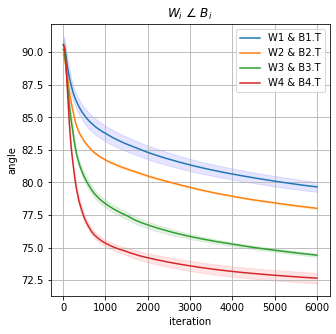

In [ ]:
# angle between backward weights and forward weights
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment[:,0,:].cpu().numpy(),axis=(0)))
ax.plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment[:,1,:].cpu().numpy(),axis=(0)))
ax.plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment[:,2,:].cpu().numpy(),axis=(0)))
ax.plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment[:,3,:].cpu().numpy(),axis=(0)))


ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment[:,0,:].cpu().numpy(),axis=(0))-np.std(alignment[:,0,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment[:,0,:].cpu().numpy(),axis=(0))+np.std(alignment[:,0,:].cpu().numpy(),axis=(0))/2,\
                color='blue', alpha=.1); 

ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment[:,1,:].cpu().numpy(),axis=(0))-np.std(alignment[:,1,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment[:,1,:].cpu().numpy(),axis=(0))+np.std(alignment[:,1,:].cpu().numpy(),axis=(0))/2,\
                color='orange', alpha=.1);           

ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment[:,2,:].cpu().numpy(),axis=(0))-np.std(alignment[:,2,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment[:,2,:].cpu().numpy(),axis=(0))+np.std(alignment[:,2,:].cpu().numpy(),axis=(0))/2,\
                color='green', alpha=.1);     
                
ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment[:,3,:].cpu().numpy(),axis=(0))-np.std(alignment[:,3,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment[:,3,:].cpu().numpy(),axis=(0))+np.std(alignment[:,3,:].cpu().numpy(),axis=(0))/2,\
                color='red', alpha=.1); 


ax.set_title(r'$W_i$ $\angle$ $B_i$')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.legend(['W1 & B1.T','W2 & B2.T','W3 & B3.T','W4 & B4.T'],loc='best')
ax.grid(True)

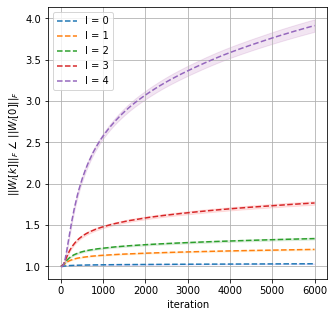

In [ ]:
# wk norm to w0 norm
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(np.arange(1,epoch_num*batch_num+1),np.mean(w0_wk[:,0,:].cpu().numpy(),axis=(0)),'--')
ax.plot(np.arange(1,epoch_num*batch_num+1),np.mean(w0_wk[:,1,:].cpu().numpy(),axis=(0)),'--')
ax.plot(np.arange(1,epoch_num*batch_num+1),np.mean(w0_wk[:,2,:].cpu().numpy(),axis=(0)),'--')
ax.plot(np.arange(1,epoch_num*batch_num+1),np.mean(w0_wk[:,3,:].cpu().numpy(),axis=(0)),'--')
ax.plot(np.arange(1,epoch_num*batch_num+1),np.mean(w0_wk[:,4,:].cpu().numpy(),axis=(0)),'--')



ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(w0_wk[:,0,:].cpu().numpy(),axis=(0))-np.std(w0_wk[:,0,:].cpu().numpy(),axis=(0))/2,\
                np.mean(w0_wk[:,0,:].cpu().numpy(),axis=(0))+np.std(w0_wk[:,0,:].cpu().numpy(),axis=(0))/2,\
                color='blue', alpha=.1); 

ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(w0_wk[:,1,:].cpu().numpy(),axis=(0))-np.std(w0_wk[:,1,:].cpu().numpy(),axis=(0))/2,\
                np.mean(w0_wk[:,1,:].cpu().numpy(),axis=(0))+np.std(w0_wk[:,1,:].cpu().numpy(),axis=(0))/2,\
                color='orange', alpha=.1);           

ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(w0_wk[:,2,:].cpu().numpy(),axis=(0))-np.std(w0_wk[:,2,:].cpu().numpy(),axis=(0))/2,\
                np.mean(w0_wk[:,2,:].cpu().numpy(),axis=(0))+np.std(w0_wk[:,2,:].cpu().numpy(),axis=(0))/2,\
                color='green', alpha=.1);     
                
ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(w0_wk[:,3,:].cpu().numpy(),axis=(0))-np.std(w0_wk[:,3,:].cpu().numpy(),axis=(0))/2,\
                np.mean(w0_wk[:,3,:].cpu().numpy(),axis=(0))+np.std(w0_wk[:,3,:].cpu().numpy(),axis=(0))/2,\
                color='red', alpha=.1); 

ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(w0_wk[:,4,:].cpu().numpy(),axis=(0))-np.std(w0_wk[:,4,:].cpu().numpy(),axis=(0))/2,\
                np.mean(w0_wk[:,4,:].cpu().numpy(),axis=(0))+np.std(w0_wk[:,4,:].cpu().numpy(),axis=(0))/2,\
                color='purple', alpha=.1); 



ax.set_ylabel(r'$||W_l [k]||_F$ $\angle$ $||W_l [0]||_F$')
ax.set_xlabel('iteration')
ax.legend(['l = 0','l = 1','l = 2','l = 3','l = 4'],loc='best')
ax.grid(True)

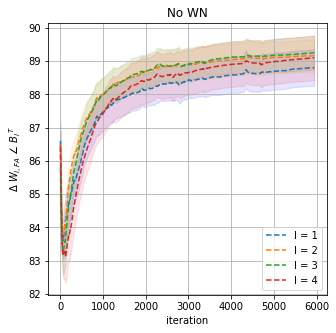

In [ ]:
# plot the angle between delta w and B.T - Fig 7E

window_size = 60

# plot
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(np.arange(1,epoch_num*batch_num+2-window_size),moving_avg(np.mean(alignment_dw_fa_B[:,0,:].cpu().numpy(),axis=(0)), window_size),'--')
ax.plot(np.arange(1,epoch_num*batch_num+2-window_size),moving_avg(np.mean(alignment_dw_fa_B[:,1,:].cpu().numpy(),axis=(0)), window_size),'--')
ax.plot(np.arange(1,epoch_num*batch_num+2-window_size),moving_avg(np.mean(alignment_dw_fa_B[:,2,:].cpu().numpy(),axis=(0)), window_size),'--')
ax.plot(np.arange(1,epoch_num*batch_num+2-window_size),moving_avg(np.mean(alignment_dw_fa_B[:,3,:].cpu().numpy(),axis=(0)), window_size),'--')



ax.fill_between(np.arange(1,epoch_num*batch_num+2-window_size),\
                moving_avg(np.mean(alignment_dw_fa_B[:,0,:].cpu().numpy(),axis=(0))-np.std(alignment_dw_fa_B[:,0,:].cpu().numpy(),axis=(0))/2, window_size),\
                moving_avg(np.mean(alignment_dw_fa_B[:,0,:].cpu().numpy(),axis=(0))+np.std(alignment_dw_fa_B[:,0,:].cpu().numpy(),axis=(0))/2, window_size),\
                color='blue', alpha=.1); 

ax.fill_between(np.arange(1,epoch_num*batch_num+2-window_size),\
                moving_avg(np.mean(alignment_dw_fa_B[:,1,:].cpu().numpy(),axis=(0))-np.std(alignment_dw_fa_B[:,1,:].cpu().numpy(),axis=(0))/2, window_size),\
                moving_avg(np.mean(alignment_dw_fa_B[:,1,:].cpu().numpy(),axis=(0))+np.std(alignment_dw_fa_B[:,1,:].cpu().numpy(),axis=(0))/2, window_size),\
                color='orange', alpha=.1);           

ax.fill_between(np.arange(1,epoch_num*batch_num+2-window_size),\
                moving_avg(np.mean(alignment_dw_fa_B[:,2,:].cpu().numpy(),axis=(0))-np.std(alignment_dw_fa_B[:,2,:].cpu().numpy(),axis=(0))/2, window_size),\
                moving_avg(np.mean(alignment_dw_fa_B[:,2,:].cpu().numpy(),axis=(0))+np.std(alignment_dw_fa_B[:,2,:].cpu().numpy(),axis=(0))/2, window_size),\
                color='green', alpha=.1);     
                
ax.fill_between(np.arange(1,epoch_num*batch_num+2-window_size),\
                moving_avg(np.mean(alignment_dw_fa_B[:,3,:].cpu().numpy(),axis=(0))-np.std(alignment_dw_fa_B[:,3,:].cpu().numpy(),axis=(0))/2, window_size),\
                moving_avg(np.mean(alignment_dw_fa_B[:,3,:].cpu().numpy(),axis=(0))+np.std(alignment_dw_fa_B[:,3,:].cpu().numpy(),axis=(0))/2, window_size),\
                color='red', alpha=.1); 



ax.set_title('No WN')
ax.set_ylabel(r'$\Delta$ $W_{l,FA}$ $\angle$ ${B_l}^T$')
ax.set_xlabel('iteration')
ax.legend(['l = 1','l = 2','l = 3','l = 4'],loc='best')
ax.grid(True)

(100, 2, 65, 4)


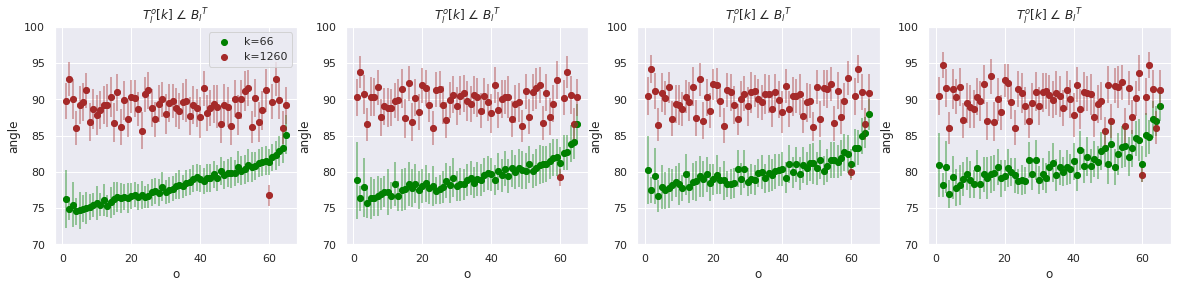

In [ ]:
# normal plots - aligment terms & Backward weights alignment


print(angles_alignment_terms.shape)
fig, ax = plt.subplots(1,4,figsize=(20,4))


# mean
ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,0],axis=0),color = "green")
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,1],axis=0),color = "green")
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,2],axis=0),color = "green")
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,3],axis=0),color = "green")

ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,0],axis=0),color = "brown")
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,1],axis=0),color = "brown")
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,2],axis=0),color = "brown")
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,3],axis=0),color = "brown")

# errorbars
ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,0],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,0],axis=0),fmt="o",color = "green",alpha=0.5)
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,1],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,1],axis=0), fmt="o",color = "green",alpha=0.5)
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,2],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,2],axis=0), fmt="o",color = "green",alpha=0.5)
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,3],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,3],axis=0), fmt="o",color = "green",alpha=0.5)

ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,0],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,0],axis=0), fmt="o",color = "brown",alpha=0.5)
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,1],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,1],axis=0), fmt="o",color = "brown",alpha=0.5)
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,2],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,2],axis=0), fmt="o",color = "brown",alpha=0.5)
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,3],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,3],axis=0), fmt="o",color = "brown",alpha=0.5)

# set constant xylim
ax[0].set_ylim([1, 66])
ax[1].set_ylim([1, 66])
ax[2].set_ylim([1, 66])
ax[3].set_ylim([1, 66])

ax[0].set_ylim([70, 100])
ax[1].set_ylim([70, 100])
ax[2].set_ylim([70, 100])
ax[3].set_ylim([70, 100])

# labels
ax[0].set_xlabel('o')
ax[1].set_xlabel('o')
ax[2].set_xlabel('o')
ax[3].set_xlabel('o')


# labels
ax[0].set_ylabel('angle')
ax[1].set_ylabel('angle')
ax[2].set_ylabel('angle')
ax[3].set_ylabel('angle')

# titles
ax[0].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')
ax[1].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')
ax[2].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')
ax[3].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')


ax[0].legend(['k=66','k=1260'],loc='best')


(100, 2, 65, 4)


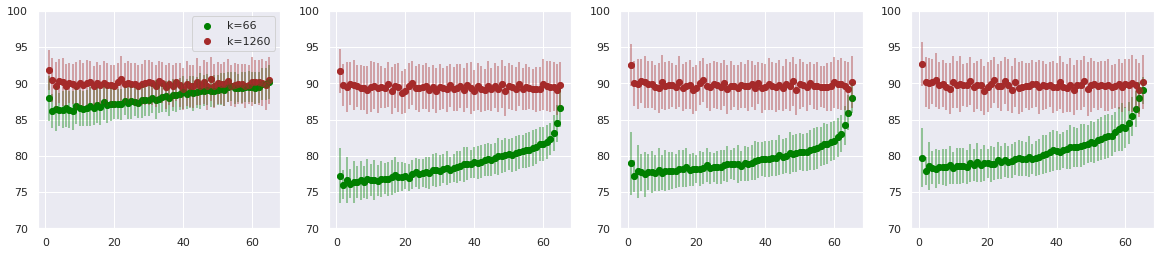

In [ ]:
# shuffled order - aligment terms & Backward weights alignment

print(angles_alignment_terms.shape)
fig, ax = plt.subplots(1,4,figsize=(20,4))


# mean
ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,0],axis=0),color = "green")
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,1],axis=0),color = "green")
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,2],axis=0),color = "green")
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,3],axis=0),color = "green")

ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,0],axis=0),color = "brown")
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,1],axis=0),color = "brown")
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,2],axis=0),color = "brown")
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,3],axis=0),color = "brown")

# errorbars
ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,0],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,0],axis=0),fmt="o",color = "green",alpha=0.5)
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,1],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,1],axis=0), fmt="o",color = "green",alpha=0.5)
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,2],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,2],axis=0), fmt="o",color = "green",alpha=0.5)
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,3],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,3],axis=0), fmt="o",color = "green",alpha=0.5)

ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,0],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,0],axis=0), fmt="o",color = "brown",alpha=0.5)
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,1],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,1],axis=0), fmt="o",color = "brown",alpha=0.5)
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,2],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,2],axis=0), fmt="o",color = "brown",alpha=0.5)
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,3],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,3],axis=0), fmt="o",color = "brown",alpha=0.5)

# set constant xylim
ax[0].set_ylim([1, 66])
ax[1].set_ylim([1, 66])
ax[2].set_ylim([1, 66])
ax[3].set_ylim([1, 66])

ax[0].set_ylim([70, 100])
ax[1].set_ylim([70, 100])
ax[2].set_ylim([70, 100])
ax[3].set_ylim([70, 100])

# labels
ax[0].set_xlabel('o')
ax[1].set_xlabel('o')
ax[2].set_xlabel('o')
ax[3].set_xlabel('o')


# labels
ax[0].set_ylabel('angle')
ax[1].set_ylabel('angle')
ax[2].set_ylabel('angle')
ax[3].set_ylabel('angle')

# titles
ax[0].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')
ax[1].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')
ax[2].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')
ax[3].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')



ax[0].legend(['k=66','k=1260'],loc='best')
ax[1].legend(['k=66','k=1260'],loc='best')
ax[2].legend(['k=66','k=1260'],loc='best')
ax[3].legend(['k=66','k=1260'],loc='best')



(30, 2, 65, 4)


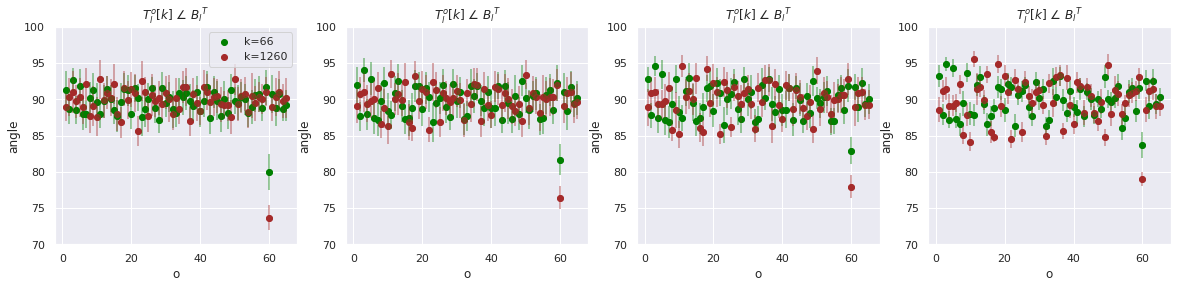

In [ ]:
# shuffled label plots - aligment terms & Backward weights alignment

print(angles_alignment_terms.shape)
fig, ax = plt.subplots(1,4,figsize=(20,4))


# mean
ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,0],axis=0),color = "green")
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,1],axis=0),color = "green")
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,2],axis=0),color = "green")
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,3],axis=0),color = "green")

ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,0],axis=0),color = "brown")
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,1],axis=0),color = "brown")
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,2],axis=0),color = "brown")
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,3],axis=0),color = "brown")

# errorbars
ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,0],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,0],axis=0),fmt="o",color = "green",alpha=0.5)
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,1],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,1],axis=0), fmt="o",color = "green",alpha=0.5)
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,2],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,2],axis=0), fmt="o",color = "green",alpha=0.5)
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,3],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,3],axis=0), fmt="o",color = "green",alpha=0.5)

ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,0],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,0],axis=0), fmt="o",color = "brown",alpha=0.5)
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,1],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,1],axis=0), fmt="o",color = "brown",alpha=0.5)
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,2],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,2],axis=0), fmt="o",color = "brown",alpha=0.5)
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,3],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,3],axis=0), fmt="o",color = "brown",alpha=0.5)

# set constant xylim
ax[0].set_ylim([1, 66])
ax[1].set_ylim([1, 66])
ax[2].set_ylim([1, 66])
ax[3].set_ylim([1, 66])

ax[0].set_ylim([70, 100])
ax[1].set_ylim([70, 100])
ax[2].set_ylim([70, 100])
ax[3].set_ylim([70, 100])

# labels
ax[0].set_xlabel('o')
ax[1].set_xlabel('o')
ax[2].set_xlabel('o')
ax[3].set_xlabel('o')


# labels
ax[0].set_ylabel('angle')
ax[1].set_ylabel('angle')
ax[2].set_ylabel('angle')
ax[3].set_ylabel('angle')

# titles
ax[0].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')
ax[1].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')
ax[2].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')
ax[3].set_title(r'$T_{l}^{o}[k]$ $\angle$ ${B_{l}}^{T}$')

ax[0].legend(['k=66','k=1260'],loc='best')
ax[1].legend(['k=66','k=1260'],loc='best')
ax[2].legend(['k=66','k=1260'],loc='best')
ax[3].legend(['k=66','k=1260'],loc='best')


In [ ]:
# for fig 6A - shuffling different percent of labels

# Load MNIST Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# fig 6 - A / different percentages of shuffling the labels
y_train_1 = shuffle(y_train, 1)
y_train_2 = shuffle(y_train, 0.8)
y_train_3 = shuffle(y_train, 0.6)
y_train_4 = shuffle(y_train, 0.4)
y_train_5 = shuffle(y_train, 0.2)
y_train_6 = y_train


# -- just for fig 6 - A 
y_train_1 = torch.from_numpy(y_train_1)
y_train_2 = torch.from_numpy(y_train_2)
y_train_3 = torch.from_numpy(y_train_3)
y_train_4 = torch.from_numpy(y_train_4)
y_train_5 = torch.from_numpy(y_train_5)
y_train_6 = torch.from_numpy(y_train_6)

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)



print('data loaded!')

11501568/11490434 [==============================] - 0s 0us/step
data loaded!


In [ ]:
# resize images to 15*15
from torchvision import transforms as trans
import torchvision.transforms.functional as Func

x_train_resized = torch.zeros((x_train.shape[0],15,15))
x_test_resized = torch.zeros((x_test.shape[0],15,15))
resize_trans = trans.Resize(15)

# resize train images
for i in range (x_train.shape[0]):
    image = x_train[i,:,:].unsqueeze(0)
    x_train_resized[i,:,:] = resize_trans(image)

    
# resize test images
for i in range (x_test.shape[0]):
    image = x_test[i,:,:].unsqueeze(0)
    x_test_resized[i,:,:] = resize_trans(image)
    
print('resizing done!')
print(x_train_resized.shape,x_test_resized.shape)


resizing done!
torch.Size([60000, 15, 15]) torch.Size([10000, 15, 15])


In [ ]:
# convert images and labels to pytorch tensors & vectorize them

x_train_flat = x_train_resized.reshape(x_train_resized.shape[0],-1)
x_test_flat = x_test_resized.reshape(x_test_resized.shape[0],-1)

x_train_flat = x_train_flat.to(dev)
x_test_flat = x_test_flat.to(dev)
y_train_1 = y_train_1.to(dev)
y_train_2 = y_train_2.to(dev)
y_train_3 = y_train_3.to(dev)
y_train_4 = y_train_4.to(dev)
y_train_5 = y_train_5.to(dev)
y_train_6 = y_train_6.to(dev)
y_test = y_test.to(dev)

print('vectorization done!')
print(x_train_flat.shape,x_test_flat.shape)

vectorization done!
torch.Size([60000, 225]) torch.Size([10000, 225])


In [ ]:
# normalize images

x_tr_norm = x_train_flat/255
x_te_norm  = x_test_flat/255


print('normalization done!')

normalization done!


In [ ]:
# n hot coding the labels
category_num = 10
output_neuron_num = 50
n = int(output_neuron_num/category_num)

# encoding the categroies
categories_nhot = torch.zeros((category_num,output_neuron_num), device=dev)
codes = torch.randperm(output_neuron_num, device=dev)

for i in range(category_num):
    categories_nhot[i,codes[i*n:(i+1)*n]] = 1 
    
y_train_nhot_1 = n_hot_coder(y_train_1,n,categories_nhot,output_neuron_num)
y_train_nhot_2 = n_hot_coder(y_train_2,n,categories_nhot,output_neuron_num)
y_train_nhot_3 = n_hot_coder(y_train_3,n,categories_nhot,output_neuron_num)
y_train_nhot_4 = n_hot_coder(y_train_4,n,categories_nhot,output_neuron_num)
y_train_nhot_5 = n_hot_coder(y_train_5,n,categories_nhot,output_neuron_num)
y_train_nhot_6 = n_hot_coder(y_train_6,n,categories_nhot,output_neuron_num)
y_train_nhot_shuffleds = [y_train_nhot_1, y_train_nhot_2, y_train_nhot_3, y_train_nhot_4,\
                y_train_nhot_5, y_train_nhot_6]
                
y_test_nhot = n_hot_coder(y_test,n,categories_nhot,output_neuron_num)

print('n hot coding done!')


n hot coding done!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# create the network weights and biases from N(mu,sigma)
mu = 0
sigma = 0.1

# each layer size
input_layer_size = 225
hidden_layer1_size = 50
hidden_layer2_size = 50
hidden_layer3_size = 50
hidden_layer4_size = 50
output_layer_size = 50


network parameters created!


In [ ]:
import pandas as pd
import gc

gc.collect()
# run the network - calculate alignment terms and angles between B and W simultaneously

LR = 0.0005
batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
epoch_num = 100
run_num = 30


accuracy_training = torch.zeros((run_num,batch_num,epoch_num), device=dev)
loss_training = torch.zeros((run_num,batch_num,epoch_num), device=dev)

# angle between B & W
alignment_shuffleds = []

for kk in range(len(y_train_nhot_shuffleds)):

  alignment = torch.zeros((run_num,4,batch_num*epoch_num), device=dev)

  for k in range(run_num):
    print( 'training set', kk, ' | run ', k, ' ...')

    # create network parameters
    w0, w1, w2, w3, w4, B4, B3, B2, B1, b1, b2, b3, b4, b5 = \
    create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                      hidden_layer3_size,hidden_layer4_size,output_layer_size)

    for j in range(epoch_num):

      order = torch.arange(0,batch_num+1) # not shuffled

      for i in range(batch_num):
        # forward
        z1 = torch.matmul(input_layer[order[i],:,:],w0) + b1
        hidden_layer1 = torch.tanh(ReLU(z1))
        z2 = torch.matmul(hidden_layer1,w1) + b2
        hidden_layer2 = torch.tanh(ReLU(z2))
        z3 = torch.matmul(hidden_layer2,w2) + b3
        hidden_layer3 = torch.tanh(ReLU(z3))
        z4 = torch.matmul(hidden_layer3,w3) + b4
        hidden_layer4 = torch.tanh(ReLU(z4))
        z5 = torch.matmul(hidden_layer4,w4) + b5
        output_layer = torch.tanh(ReLU(z5))
        
        # backward the error
        E = y_train_nhot_shuffleds[kk][order[i]*batch_size:(order[i]+1)*batch_size,:]-output_layer
        delta5 = torch.multiply(E,tanh_Relu_deriv(z5))
        delta4 = torch.multiply(torch.matmul(delta5,B4),tanh_Relu_deriv(z4))
        delta3 = torch.multiply(torch.matmul(delta4,B3),tanh_Relu_deriv(z3))
        delta2 = torch.multiply(torch.matmul(delta3,B2),tanh_Relu_deriv(z2))
        delta1 = torch.multiply(torch.matmul(delta2,B1),tanh_Relu_deriv(z1))
            
        
        # update forward weights 
        w4 += LR*torch.matmul(hidden_layer4.T,delta5)
        w3 += LR*torch.matmul(hidden_layer3.T,delta4)
        w2 += LR*torch.matmul(hidden_layer2.T,delta3)
        w1 += LR*torch.matmul(hidden_layer1.T,delta2)
        w0 += LR*torch.matmul(input_layer[order[i],:,:].T,delta1)
        
        # update biases
        J = torch.ones((1,batch_size), device=dev)
        b5 += torch.squeeze(LR*torch.matmul(J,delta5))
        b4 += torch.squeeze(LR*torch.matmul(J,delta4))
        b3 += torch.squeeze(LR*torch.matmul(J,delta3))
        b2 += torch.squeeze(LR*torch.matmul(J,delta2))
        b1 += torch.squeeze(LR*torch.matmul(J,delta1))
        
        # binarize output
        n = 5 # n hot
        output_layer_binarized = binarize_output(output_layer,n,categories_nhot)

        # loss values
        loss_training[k,i,j] = loss_function(output_layer,y_train_nhot_shuffleds[kk][order[i]*batch_size:(order[i]+1)*batch_size,:])
        accuracy_training[k,i,j] = accuracy_cal(output_layer_binarized,y_train_nhot_shuffleds[kk][order[i]*batch_size:(order[i]+1)*batch_size,:]);

          
      print(torch.mean(accuracy_training[k,:,j]),torch.mean(loss_training[k,:,j]))

  alignment_shuffleds.append(alignment)
print('network training done!')

NameError: ignored

torch.Size([30, 6000])


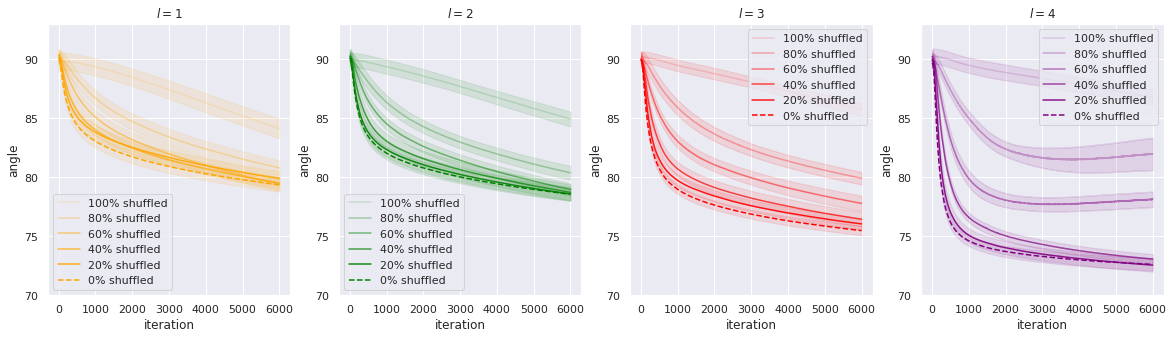

In [ ]:
# angle between backward weights and forward weights
fig, ax = plt.subplots(1,4,figsize=(20,5))

print(alignment_shuffleds[0][:,0,:].shape)


# l1
ax[0].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[0][:,0,:].cpu().numpy(),axis=(0)),alpha=.15,color='orange')
ax[0].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[1][:,0,:].cpu().numpy(),axis=(0)),alpha=.30,color='orange')
ax[0].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[2][:,0,:].cpu().numpy(),axis=(0)),alpha=.50,color='orange')
ax[0].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[3][:,0,:].cpu().numpy(),axis=(0)),alpha=.70,color='orange')
ax[0].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[4][:,0,:].cpu().numpy(),axis=(0)),alpha=.90,color='orange')
ax[0].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[5][:,0,:].cpu().numpy(),axis=(0)),'--',alpha=1,color='orange')

ax[0].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[0][:,0,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[0][:,0,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[0][:,0,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[0][:,0,:].cpu().numpy(),axis=(0))/2,\
                color='orange', alpha=.1); 

ax[0].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[1][:,0,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[1][:,0,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[1][:,0,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[1][:,0,:].cpu().numpy(),axis=(0))/2,\
                color='orange', alpha=.1);           

ax[0].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[2][:,0,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[2][:,0,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[2][:,0,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[2][:,0,:].cpu().numpy(),axis=(0))/2,\
                color='orange', alpha=.1);     
                
ax[0].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[3][:,0,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[3][:,0,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[3][:,0,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[3][:,0,:].cpu().numpy(),axis=(0))/2,\
                color='orange', alpha=.1); 
           
ax[0].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[4][:,0,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[4][:,0,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[4][:,0,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[4][:,0,:].cpu().numpy(),axis=(0))/2,\
                color='orange', alpha=.1); 
           

ax[0].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[5][:,0,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[5][:,0,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[5][:,0,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[5][:,0,:].cpu().numpy(),axis=(0))/2,\
                color='orange', alpha=.1); 
           

ax[0].set_ylabel('angle')
ax[0].set_xlabel('iteration')
ax[0].set_title(r'$l=1$')
ax[0].legend(['100% shuffled','80% shuffled','60% shuffled','40% shuffled','20% shuffled','0% shuffled'],loc='best')
ax[0].grid(True)



# l2
ax[1].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[0][:,1,:].cpu().numpy(),axis=(0)),alpha=.15,color='green')
ax[1].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[1][:,1,:].cpu().numpy(),axis=(0)),alpha=.30,color='green')
ax[1].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[2][:,1,:].cpu().numpy(),axis=(0)),alpha=.50,color='green')
ax[1].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[3][:,1,:].cpu().numpy(),axis=(0)),alpha=.70,color='green')
ax[1].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[4][:,1,:].cpu().numpy(),axis=(0)),alpha=.90,color='green')
ax[1].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[5][:,1,:].cpu().numpy(),axis=(0)),'--',alpha=1,color='green')

ax[1].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[0][:,1,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[0][:,1,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[0][:,1,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[0][:,1,:].cpu().numpy(),axis=(0))/2,\
                color='green', alpha=.1); 

ax[1].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[1][:,1,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[1][:,1,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[1][:,1,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[1][:,1,:].cpu().numpy(),axis=(0))/2,\
                color='green', alpha=.1);           

ax[1].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[2][:,1,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[2][:,1,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[2][:,1,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[2][:,1,:].cpu().numpy(),axis=(0))/2,\
                color='green', alpha=.1);     
                
ax[1].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[3][:,1,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[3][:,1,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[3][:,1,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[3][:,1,:].cpu().numpy(),axis=(0))/2,\
                color='green', alpha=.1); 
           
ax[1].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[4][:,1,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[4][:,1,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[4][:,1,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[4][:,1,:].cpu().numpy(),axis=(0))/2,\
                color='green', alpha=.1); 
           

ax[1].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[5][:,1,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[5][:,1,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[5][:,1,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[5][:,1,:].cpu().numpy(),axis=(0))/2,\
                color='green', alpha=.1); 
           

ax[1].set_ylabel('angle')
ax[1].set_xlabel('iteration')
ax[1].set_title(r'$l=2$')
ax[1].legend(['100% shuffled','80% shuffled','60% shuffled','40% shuffled','20% shuffled','0% shuffled'],loc='best')
ax[1].grid(True)

# l3
ax[2].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[0][:,2,:].cpu().numpy(),axis=(0)),alpha=.15,color='red')
ax[2].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[1][:,2,:].cpu().numpy(),axis=(0)),alpha=.30,color='red')
ax[2].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[2][:,2,:].cpu().numpy(),axis=(0)),alpha=.50,color='red')
ax[2].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[3][:,2,:].cpu().numpy(),axis=(0)),alpha=.70,color='red')
ax[2].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[4][:,2,:].cpu().numpy(),axis=(0)),alpha=.90,color='red')
ax[2].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[5][:,2,:].cpu().numpy(),axis=(0)),'--',alpha=1,color='red')

ax[2].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[0][:,2,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[0][:,2,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[0][:,2,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[0][:,2,:].cpu().numpy(),axis=(0))/2,\
                color='red', alpha=.1); 

ax[2].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[1][:,2,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[1][:,2,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[1][:,2,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[1][:,2,:].cpu().numpy(),axis=(0))/2,\
                color='red', alpha=.1);           

ax[2].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[2][:,2,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[2][:,2,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[2][:,2,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[2][:,2,:].cpu().numpy(),axis=(0))/2,\
                color='red', alpha=.1);     
                
ax[2].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[3][:,2,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[3][:,2,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[3][:,2,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[3][:,2,:].cpu().numpy(),axis=(0))/2,\
                color='red', alpha=.1); 
           
ax[2].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[4][:,2,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[4][:,2,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[4][:,2,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[4][:,2,:].cpu().numpy(),axis=(0))/2,\
                color='red', alpha=.1); 
           

ax[2].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[5][:,2,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[5][:,2,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[5][:,2,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[5][:,2,:].cpu().numpy(),axis=(0))/2,\
                color='red', alpha=.1); 
           

ax[2].set_ylabel('angle')
ax[2].set_xlabel('iteration')
ax[2].set_title(r'$l=3$')
ax[2].legend(['100% shuffled','80% shuffled','60% shuffled','40% shuffled','20% shuffled','0% shuffled'],loc='best')
ax[2].grid(True)


# l4
ax[3].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[0][:,3,:].cpu().numpy(),axis=(0)),alpha=.15,color="purple")
ax[3].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[1][:,3,:].cpu().numpy(),axis=(0)),alpha=.30,color="purple")
ax[3].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[2][:,3,:].cpu().numpy(),axis=(0)),alpha=.50,color="purple")
ax[3].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[3][:,3,:].cpu().numpy(),axis=(0)),alpha=.70,color="purple")
ax[3].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[4][:,3,:].cpu().numpy(),axis=(0)),alpha=.90,color="purple")
ax[3].plot(np.arange(1,epoch_num*batch_num+1),np.mean(alignment_shuffleds[5][:,3,:].cpu().numpy(),axis=(0)),'--',alpha=1,color="purple")

ax[3].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[0][:,3,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[0][:,3,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[0][:,3,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[0][:,3,:].cpu().numpy(),axis=(0))/2,\
                color='purple', alpha=.1); 

ax[3].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[1][:,3,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[1][:,3,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[1][:,3,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[1][:,3,:].cpu().numpy(),axis=(0))/2,\
                color='purple', alpha=.1);           

ax[3].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[2][:,3,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[2][:,3,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[2][:,3,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[2][:,3,:].cpu().numpy(),axis=(0))/2,\
                color='purple', alpha=.1);     
                
ax[3].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[3][:,3,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[3][:,3,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[3][:,3,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[3][:,3,:].cpu().numpy(),axis=(0))/2,\
                color='purple', alpha=.1); 
           
ax[3].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[4][:,3,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[4][:,3,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[4][:,3,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[4][:,3,:].cpu().numpy(),axis=(0))/2,\
                color='purple', alpha=.1); 
           

ax[3].fill_between(np.arange(1,epoch_num*batch_num+1),\
                np.mean(alignment_shuffleds[5][:,3,:].cpu().numpy(),axis=(0))-np.std(alignment_shuffleds[5][:,3,:].cpu().numpy(),axis=(0))/2,\
                np.mean(alignment_shuffleds[5][:,3,:].cpu().numpy(),axis=(0))+np.std(alignment_shuffleds[5][:,3,:].cpu().numpy(),axis=(0))/2,\
                color='purple', alpha=.1); 
           

ax[3].set_ylabel('angle')
ax[3].set_xlabel('iteration')
ax[3].set_title(r'$l=4$')
ax[3].legend(['100% shuffled','80% shuffled','60% shuffled','40% shuffled','20% shuffled','0% shuffled'],loc='best')
ax[3].grid(True)

ax[0].set_ylim([70, 93]);
ax[1].set_ylim([70, 93]);
ax[2].set_ylim([70, 93]);
ax[3].set_ylim([70, 93]);

In [ ]:
######################################## feedback alignment and backpropagation comparing
import pandas as pd
import gc

gc.collect()
# run the network - calculate alignment terms and angles between B and W simultaneously

LR = 0.0005
batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
epoch_num = 100
run_num = 10


accuracy_training_bp = torch.zeros((run_num,batch_num,epoch_num), device=dev)
loss_training_bp = torch.zeros((run_num,batch_num,epoch_num), device=dev)

accuracy_training_fa = torch.zeros((run_num,batch_num,epoch_num), device=dev)
loss_training_fa = torch.zeros((run_num,batch_num,epoch_num), device=dev)

loss_test_bp = torch.zeros((run_num,epoch_num), device=dev)
loss_test_fa = torch.zeros((run_num,epoch_num), device=dev)


# angle between delta W FA and BP - for fig 7C
alignment_dw_fa_bp = torch.zeros((run_num,5,batch_num*epoch_num), device=dev)


for k in range(run_num):
  print('run ', k, ' ...')

  # create network parameters for FA
  w0_fa, w1_fa, w2_fa, w3_fa, w4_fa, B4_fa, B3_fa, B2_fa, B1_fa, b1_fa, b2_fa, b3_fa, b4_fa, b5_fa = \
  create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                    hidden_layer3_size,hidden_layer4_size,output_layer_size)
  

  # same initials for BP
  w0_bp = torch.clone(w0_fa)
  w1_bp = torch.clone(w1_fa)
  w2_bp = torch.clone(w2_fa)
  w3_bp = torch.clone(w3_fa)
  w4_bp = torch.clone(w4_fa)

  B1_bp = w1_bp.T
  B2_bp = w2_bp.T
  B3_bp = w3_bp.T
  B4_bp = w4_bp.T

  b1_bp = torch.clone(b1_fa)
  b2_bp = torch.clone(b2_fa)
  b3_bp = torch.clone(b3_fa)
  b4_bp = torch.clone(b4_fa)
  b5_bp = torch.clone(b5_fa)

  for j in range(epoch_num):

    for i in range(batch_num):

          ############### Feedback alignment
          # forward FA
          z1_fa = torch.matmul(input_layer[i,:,:],w0_fa) + b1_fa
          hidden_layer1_fa = torch.tanh(ReLU(z1_fa))
          z2_fa = torch.matmul(hidden_layer1_fa,w1_fa) + b2_fa
          hidden_layer2_fa = torch.tanh(ReLU(z2_fa))
          z3_fa = torch.matmul(hidden_layer2_fa,w2_fa) + b3_fa
          hidden_layer3_fa = torch.tanh(ReLU(z3_fa))
          z4_fa = torch.matmul(hidden_layer3_fa,w3_fa) + b4_fa
          hidden_layer4_fa = torch.tanh(ReLU(z4_fa))
          z5_fa = torch.matmul(hidden_layer4_fa,w4_fa) + b5_fa
          output_layer_fa = torch.tanh(ReLU(z5_fa))
          
          # backward the error FA
          E_fa = y_train_nhot[i*batch_size:(i+1)*batch_size,:]-output_layer_fa
          delta5_fa = torch.multiply(E_fa,tanh_Relu_deriv(z5_fa))
          delta4_fa = torch.multiply(torch.matmul(delta5_fa,B4_fa),tanh_Relu_deriv(z4_fa))
          delta3_fa = torch.multiply(torch.matmul(delta4_fa,B3_fa),tanh_Relu_deriv(z3_fa))
          delta2_fa = torch.multiply(torch.matmul(delta3_fa,B2_fa),tanh_Relu_deriv(z2_fa))
          delta1_fa = torch.multiply(torch.matmul(delta2_fa,B1_fa),tanh_Relu_deriv(z1_fa))           
          
          # update forward weights for FA
          w4_fa += LR*torch.matmul(hidden_layer4_fa.T,delta5_fa)
          w3_fa += LR*torch.matmul(hidden_layer3_fa.T,delta4_fa)
          w2_fa += LR*torch.matmul(hidden_layer2_fa.T,delta3_fa)
          w1_fa += LR*torch.matmul(hidden_layer1_fa.T,delta2_fa)
          w0_fa += LR*torch.matmul(input_layer[i,:,:].T,delta1_fa)


          # update biases for FA
          J_fa = torch.ones((1,batch_size), device=dev)
          b5_fa += torch.squeeze(LR*torch.matmul(J_fa,delta5_fa))
          b4_fa += torch.squeeze(LR*torch.matmul(J_fa,delta4_fa))
          b3_fa += torch.squeeze(LR*torch.matmul(J_fa,delta3_fa))
          b2_fa += torch.squeeze(LR*torch.matmul(J_fa,delta2_fa))
          b1_fa += torch.squeeze(LR*torch.matmul(J_fa,delta1_fa))

          # binarize output for FA
          n = 5 # n hot
          output_layer_binarized_fa = binarize_output(output_layer_fa,n,categories_nhot)

          # loss values for FA
          loss_training_fa[k,i,j] = loss_function(output_layer_fa,y_train_nhot[i*batch_size:(i+1)*batch_size,:])
          accuracy_training_fa[k,i,j] = accuracy_cal(output_layer_binarized_fa,y_train_nhot[i*batch_size:(i+1)*batch_size,:])
          
          # save delta w for FA
          delta5_fa_inTime = LR*torch.matmul(hidden_layer4_fa.T,delta5_fa)
          delta4_fa_inTime = LR*torch.matmul(hidden_layer3_fa.T,delta4_fa)
          delta3_fa_inTime = LR*torch.matmul(hidden_layer2_fa.T,delta3_fa)
          delta2_fa_inTime = LR*torch.matmul(hidden_layer1_fa.T,delta2_fa)
          delta1_fa_inTime = LR*torch.matmul(input_layer[i,:,:].T,delta1_fa)


          ############### Back Propagation
          # forward BP
          z1_bp = torch.matmul(input_layer[i,:,:],w0_bp) + b1_bp
          hidden_layer1_bp = torch.tanh(ReLU(z1_bp))
          z2_bp = torch.matmul(hidden_layer1_bp,w1_bp) + b2_bp
          hidden_layer2_bp = torch.tanh(ReLU(z2_bp))
          z3_bp = torch.matmul(hidden_layer2_bp,w2_bp) + b3_bp
          hidden_layer3_bp = torch.tanh(ReLU(z3_bp))
          z4_bp = torch.matmul(hidden_layer3_bp,w3_bp) + b4_bp
          hidden_layer4_bp = torch.tanh(ReLU(z4_bp))
          z5_bp = torch.matmul(hidden_layer4_bp,w4_bp) + b5_bp
          output_layer_bp = torch.tanh(ReLU(z5_bp))
          
          # backward the error BP
          E_bp = y_train_nhot[i*batch_size:(i+1)*batch_size,:]-output_layer_bp
          delta5_bp = torch.multiply(E_bp,tanh_Relu_deriv(z5_bp))
          delta4_bp = torch.multiply(torch.matmul(delta5_bp,B4_bp),tanh_Relu_deriv(z4_bp))
          delta3_bp = torch.multiply(torch.matmul(delta4_bp,B3_bp),tanh_Relu_deriv(z3_bp))
          delta2_bp = torch.multiply(torch.matmul(delta3_bp,B2_bp),tanh_Relu_deriv(z2_bp))
          delta1_bp = torch.multiply(torch.matmul(delta2_bp,B1_bp),tanh_Relu_deriv(z1_bp))           
          
          # update forward weights for BP
          w4_bp += LR*torch.matmul(hidden_layer4_bp.T,delta5_bp)
          w3_bp += LR*torch.matmul(hidden_layer3_bp.T,delta4_bp)
          w2_bp += LR*torch.matmul(hidden_layer2_bp.T,delta3_bp)
          w1_bp += LR*torch.matmul(hidden_layer1_bp.T,delta2_bp)
          w0_bp += LR*torch.matmul(input_layer[i,:,:].T,delta1_bp)

          # update backward weights for BP
          B4_bp = w4_bp.T
          B3_bp = w3_bp.T
          B2_bp = w2_bp.T
          B1_bp = w1_bp.T


          # update biases for BP
          J_bp = torch.ones((1,batch_size), device=dev)
          b5_bp += torch.squeeze(LR*torch.matmul(J_bp,delta5_bp))
          b4_bp += torch.squeeze(LR*torch.matmul(J_bp,delta4_bp))
          b3_bp += torch.squeeze(LR*torch.matmul(J_bp,delta3_bp))
          b2_bp += torch.squeeze(LR*torch.matmul(J_bp,delta2_bp))
          b1_bp += torch.squeeze(LR*torch.matmul(J_bp,delta1_bp))

          # binarize output for BP
          n = 5 # n hot
          output_layer_binarized_bp = binarize_output(output_layer_bp,n,categories_nhot)

          # loss value & accuracy of training for BP
          loss_training_bp[k,i,j] = loss_function(output_layer_bp,y_train_nhot[i*batch_size:(i+1)*batch_size,:])
          accuracy_training_bp[k,i,j] = accuracy_cal(output_layer_binarized_bp,y_train_nhot[i*batch_size:(i+1)*batch_size,:])

          # save delta w for BP
          delta5_bp_inTime = LR*torch.matmul(hidden_layer4_bp.T,delta5_bp)
          delta4_bp_inTime = LR*torch.matmul(hidden_layer3_bp.T,delta4_bp)
          delta3_bp_inTime = LR*torch.matmul(hidden_layer2_bp.T,delta3_bp)
          delta2_bp_inTime = LR*torch.matmul(hidden_layer1_bp.T,delta2_bp)
          delta1_bp_inTime = LR*torch.matmul(input_layer[i,:,:].T,delta1_bp)

          # cal the alignment
          alignment_dw_fa_bp[k,0,j*batch_num+i] = angleCal(delta1_bp_inTime,delta1_fa_inTime)
          alignment_dw_fa_bp[k,1,j*batch_num+i] = angleCal(delta2_bp_inTime,delta2_fa_inTime)
          alignment_dw_fa_bp[k,2,j*batch_num+i] = angleCal(delta3_bp_inTime,delta3_fa_inTime)
          alignment_dw_fa_bp[k,3,j*batch_num+i] = angleCal(delta4_bp_inTime,delta4_fa_inTime)
          alignment_dw_fa_bp[k,4,j*batch_num+i] = angleCal(delta5_bp_inTime,delta5_fa_inTime)

        
    # loss value of test data for FA
    _, loss_test_fa[k,j] = loss_val_testdata(w0_fa,w1_fa,w2_fa,w3_fa,w4_fa,b1_fa,b2_fa,b3_fa,b4_fa,b5_fa,categories_nhot,y_test_nhot,x_te_norm)
    # loss value of test data for BP
    _, loss_test_bp[k,j] = loss_val_testdata(w0_bp,w1_bp,w2_bp,w3_bp,w4_bp,b1_bp,b2_bp,b3_bp,b4_bp,b5_bp,categories_nhot,y_test_nhot,x_te_norm)

print('network training done!')

run  0  ...
network parameters created!
accuracy:  tensor(28.7500, device='cuda:0')  | loss value:  tensor(3.5625, device='cuda:0')
accuracy:  tensor(57.7700, device='cuda:0')  | loss value:  tensor(2.1115, device='cuda:0')
accuracy:  tensor(52.3700, device='cuda:0')  | loss value:  tensor(2.3815, device='cuda:0')
accuracy:  tensor(67.2800, device='cuda:0')  | loss value:  tensor(1.6360, device='cuda:0')
accuracy:  tensor(65.5900, device='cuda:0')  | loss value:  tensor(1.7205, device='cuda:0')
accuracy:  tensor(88.9600, device='cuda:0')  | loss value:  tensor(0.5520, device='cuda:0')
accuracy:  tensor(69.0700, device='cuda:0')  | loss value:  tensor(1.5465, device='cuda:0')
accuracy:  tensor(91.3200, device='cuda:0')  | loss value:  tensor(0.4340, device='cuda:0')
accuracy:  tensor(71.7300, device='cuda:0')  | loss value:  tensor(1.4135, device='cuda:0')
accuracy:  tensor(92.6000, device='cuda:0')  | loss value:  tensor(0.3700, device='cuda:0')
accuracy:  tensor(74.2700, device='cuda:

KeyboardInterrupt: ignored

In [ ]:
########### training accuracy
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(np.arange(1,epoch_num+1),np.mean(accuracy_training_fa.cpu().numpy(),axis=(0,1)))
ax[1].plot(np.arange(1,epoch_num+1),np.mean(loss_training_fa.cpu().numpy(),axis=(0,1)))
ax[0].plot(np.arange(1,epoch_num+1),np.mean(accuracy_training_bp.cpu().numpy(),axis=(0,1)))
ax[1].plot(np.arange(1,epoch_num+1),np.mean(loss_training_bp.cpu().numpy(),axis=(0,1)))

ax[0].fill_between(np.arange(1,epoch_num+1),\
                np.mean(accuracy_training_fa.cpu().numpy(),axis=(0,1))-np.std(accuracy_training_fa.cpu().numpy(),axis=(0,1))/2,\
                np.mean(accuracy_training_fa.cpu().numpy(),axis=(0,1))+np.std(accuracy_training_fa.cpu().numpy(),axis=(0,1))/2,\
                color='blue', alpha=.1);
ax[1].fill_between(np.arange(1,epoch_num+1),\
                np.mean(loss_training_fa.cpu().numpy(),axis=(0,1))-np.std(loss_training_fa.cpu().numpy(),axis=(0,1))/2,\
                np.mean(loss_training_fa.cpu().numpy(),axis=(0,1))+np.std(loss_training_fa.cpu().numpy(),axis=(0,1))/2,\
                color='blue', alpha=.1); 
ax[0].fill_between(np.arange(1,epoch_num+1),\
                np.mean(accuracy_training_bp.cpu().numpy(),axis=(0,1))-np.std(accuracy_training_bp.cpu().numpy(),axis=(0,1))/2,\
                np.mean(accuracy_training_bp.cpu().numpy(),axis=(0,1))+np.std(accuracy_training_bp.cpu().numpy(),axis=(0,1))/2,\
                color='orange', alpha=.1);
ax[1].fill_between(np.arange(1,epoch_num+1),\
                np.mean(loss_training_bp.cpu().numpy(),axis=(0,1))-np.std(loss_training_bp.cpu().numpy(),axis=(0,1))/2,\
                np.mean(loss_training_bp.cpu().numpy(),axis=(0,1))+np.std(loss_training_bp.cpu().numpy(),axis=(0,1))/2,\
                color='orange', alpha=.1); 


ax[0].set_ylim(0,100)          

ax[0].set_title('training accuarcy')
ax[0].set_xlabel('iteration')
ax[1].set_title('training loss function value')
ax[1].set_xlabel('iteration')
ax[0].grid(True)
ax[1].grid(True)

########### test loss val
fig, ax = plt.subplots(1,1,figsize=(10,5))

loss_test_fa = loss_test_fa/torch.max(loss_test_fa) * 100
loss_test_bp = loss_test_bp/torch.max(loss_test_bp) * 100

ax.plot(np.arange(1,epoch_num+1),np.mean(loss_test_fa.cpu().numpy(),axis=(0)))
ax.plot(np.arange(1,epoch_num+1),np.mean(loss_test_bp.cpu().numpy(),axis=(0)))

ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(loss_test_fa.cpu().numpy(),axis=(0,1))-np.std(loss_test_fa.cpu().numpy(),axis=(0))/2,\
                np.mean(loss_test_fa.cpu().numpy(),axis=(0,1))+np.std(loss_test_fa.cpu().numpy(),axis=(0))/2,\
                color='blue', alpha=.1);
ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(loss_test_bp.cpu().numpy(),axis=(0,1))-np.std(loss_test_bp.cpu().numpy(),axis=(0))/2,\
                np.mean(loss_test_bp.cpu().numpy(),axis=(0,1))+np.std(loss_test_bp.cpu().numpy(),axis=(0))/2,\
                color='orange', alpha=.1);

ax.set_yscale('log')
ax.set_title('test loss %')
ax.set_xlabel('iteration')
ax.grid(True)



NameError: ignored

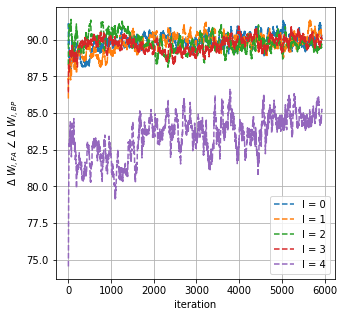

In [ ]:
# plot the angle between delta w in backpropagation and feedback alignment- Fig 7C

window_size = 60


fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(np.arange(1,epoch_num*batch_num+2-window_size),moving_avg(np.mean(alignment_dw_fa_bp[:,0,:].cpu().numpy(),axis=(0)), window_size),'--')
ax.plot(np.arange(1,epoch_num*batch_num+2-window_size),moving_avg(np.mean(alignment_dw_fa_bp[:,1,:].cpu().numpy(),axis=(0)), window_size),'--')
ax.plot(np.arange(1,epoch_num*batch_num+2-window_size),moving_avg(np.mean(alignment_dw_fa_bp[:,2,:].cpu().numpy(),axis=(0)), window_size),'--')
ax.plot(np.arange(1,epoch_num*batch_num+2-window_size),moving_avg(np.mean(alignment_dw_fa_bp[:,3,:].cpu().numpy(),axis=(0)), window_size),'--')
ax.plot(np.arange(1,epoch_num*batch_num+2-window_size),moving_avg(np.mean(alignment_dw_fa_bp[:,4,:].cpu().numpy(),axis=(0)), window_size),'--')



# ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
#                 np.mean(alignment_dw_fa_bp[:,0,:].cpu().numpy(),axis=(0))-np.std(alignment_dw_fa_bp[:,0,:].cpu().numpy(),axis=(0))/2,\
#                 np.mean(alignment_dw_fa_bp[:,0,:].cpu().numpy(),axis=(0))+np.std(alignment_dw_fa_bp[:,0,:].cpu().numpy(),axis=(0))/2,\
#                 color='blue', alpha=.1); 

# ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
#                 np.mean(alignment_dw_fa_bp[:,1,:].cpu().numpy(),axis=(0))-np.std(alignment_dw_fa_bp[:,1,:].cpu().numpy(),axis=(0))/2,\
#                 np.mean(alignment_dw_fa_bp[:,1,:].cpu().numpy(),axis=(0))+np.std(alignment_dw_fa_bp[:,1,:].cpu().numpy(),axis=(0))/2,\
#                 color='orange', alpha=.1);           

# ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
#                 np.mean(alignment_dw_fa_bp[:,2,:].cpu().numpy(),axis=(0))-np.std(alignment_dw_fa_bp[:,2,:].cpu().numpy(),axis=(0))/2,\
#                 np.mean(alignment_dw_fa_bp[:,2,:].cpu().numpy(),axis=(0))+np.std(alignment_dw_fa_bp[:,2,:].cpu().numpy(),axis=(0))/2,\
#                 color='green', alpha=.1);     
                
# ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
#                 np.mean(alignment_dw_fa_bp[:,3,:].cpu().numpy(),axis=(0))-np.std(alignment_dw_fa_bp[:,3,:].cpu().numpy(),axis=(0))/2,\
#                 np.mean(alignment_dw_fa_bp[:,3,:].cpu().numpy(),axis=(0))+np.std(alignment_dw_fa_bp[:,3,:].cpu().numpy(),axis=(0))/2,\
#                 color='red', alpha=.1); 

# ax.fill_between(np.arange(1,epoch_num*batch_num+1),\
#                 np.mean(alignment_dw_fa_bp[:,4,:].cpu().numpy(),axis=(0))-np.std(alignment_dw_fa_bp[:,4,:].cpu().numpy(),axis=(0))/2,\
#                 np.mean(alignment_dw_fa_bp[:,4,:].cpu().numpy(),axis=(0))+np.std(alignment_dw_fa_bp[:,4,:].cpu().numpy(),axis=(0))/2,\
#                 color='purple', alpha=.1); 



ax.set_ylabel(r'$\Delta$ $W_{l,FA}$ $\angle$ $\Delta$ $W_{l,BP}$')
ax.set_xlabel('iteration')
ax.legend(['l = 0','l = 1','l = 2','l = 3','l = 4'],loc='best')
ax.grid(True)

In [61]:
######################################## feedback alignment and backpropagation comparing with PCA
import pandas as pd
import gc

gc.collect()
# run the network - calculate alignment terms and angles between B and W simultaneously

LR = 0.0005
batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
epoch_num = 100
run_num = 1

num_params_FA = hidden_layer1_size + hidden_layer2_size + hidden_layer3_size + hidden_layer4_size + output_layer_size + \
  input_layer_size*hidden_layer1_size + hidden_layer1_size*hidden_layer2_size + hidden_layer2_size*hidden_layer3_size + hidden_layer3_size*hidden_layer4_size + \
  hidden_layer4_size*output_layer_size

num_params_BP = hidden_layer1_size + hidden_layer2_size + hidden_layer3_size + hidden_layer4_size + output_layer_size + \
  input_layer_size*hidden_layer1_size + hidden_layer1_size*hidden_layer2_size + hidden_layer2_size*hidden_layer3_size + hidden_layer3_size*hidden_layer4_size + \
  hidden_layer4_size*output_layer_size


all_params_FA = torch.zeros((epoch_num*batch_num,num_params_FA), device=dev)
all_params_BP = torch.zeros((epoch_num*batch_num,num_params_BP), device=dev)



for k in range(run_num):
  print('run ', k, ' ...')

  # create network parameters for FA
  w0_fa, w1_fa, w2_fa, w3_fa, w4_fa, B4_fa, B3_fa, B2_fa, B1_fa, b1_fa, b2_fa, b3_fa, b4_fa, b5_fa = \
  create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                    hidden_layer3_size,hidden_layer4_size,output_layer_size)
  

  # same initials for BP
  w0_bp = torch.clone(w0_fa)
  w1_bp = torch.clone(w1_fa)
  w2_bp = torch.clone(w2_fa)
  w3_bp = torch.clone(w3_fa)
  w4_bp = torch.clone(w4_fa)

  B1_bp = w1_bp.T
  B2_bp = w2_bp.T
  B3_bp = w3_bp.T
  B4_bp = w4_bp.T

  b1_bp = torch.clone(b1_fa)
  b2_bp = torch.clone(b2_fa)
  b3_bp = torch.clone(b3_fa)
  b4_bp = torch.clone(b4_fa)
  b5_bp = torch.clone(b5_fa)

  for j in range(epoch_num):

    for i in range(batch_num):

          ############### Feedback alignment
          # forward FA
          z1_fa = torch.matmul(input_layer[i,:,:],w0_fa) + b1_fa
          hidden_layer1_fa = torch.tanh(ReLU(z1_fa))
          z2_fa = torch.matmul(hidden_layer1_fa,w1_fa) + b2_fa
          hidden_layer2_fa = torch.tanh(ReLU(z2_fa))
          z3_fa = torch.matmul(hidden_layer2_fa,w2_fa) + b3_fa
          hidden_layer3_fa = torch.tanh(ReLU(z3_fa))
          z4_fa = torch.matmul(hidden_layer3_fa,w3_fa) + b4_fa
          hidden_layer4_fa = torch.tanh(ReLU(z4_fa))
          z5_fa = torch.matmul(hidden_layer4_fa,w4_fa) + b5_fa
          output_layer_fa = torch.tanh(ReLU(z5_fa))
          
          # backward the error FA
          E_fa = y_train_nhot[i*batch_size:(i+1)*batch_size,:]-output_layer_fa
          delta5_fa = torch.multiply(E_fa,tanh_Relu_deriv(z5_fa))
          delta4_fa = torch.multiply(torch.matmul(delta5_fa,B4_fa),tanh_Relu_deriv(z4_fa))
          delta3_fa = torch.multiply(torch.matmul(delta4_fa,B3_fa),tanh_Relu_deriv(z3_fa))
          delta2_fa = torch.multiply(torch.matmul(delta3_fa,B2_fa),tanh_Relu_deriv(z2_fa))
          delta1_fa = torch.multiply(torch.matmul(delta2_fa,B1_fa),tanh_Relu_deriv(z1_fa))           
          
          # update forward weights for FA
          w4_fa += LR*torch.matmul(hidden_layer4_fa.T,delta5_fa)
          w3_fa += LR*torch.matmul(hidden_layer3_fa.T,delta4_fa)
          w2_fa += LR*torch.matmul(hidden_layer2_fa.T,delta3_fa)
          w1_fa += LR*torch.matmul(hidden_layer1_fa.T,delta2_fa)
          w0_fa += LR*torch.matmul(input_layer[i,:,:].T,delta1_fa)


          # update biases for FA
          J_fa = torch.ones((1,batch_size), device=dev)
          b5_fa += torch.squeeze(LR*torch.matmul(J_fa,delta5_fa))
          b4_fa += torch.squeeze(LR*torch.matmul(J_fa,delta4_fa))
          b3_fa += torch.squeeze(LR*torch.matmul(J_fa,delta3_fa))
          b2_fa += torch.squeeze(LR*torch.matmul(J_fa,delta2_fa))
          b1_fa += torch.squeeze(LR*torch.matmul(J_fa,delta1_fa))

          # binarize output for FA
          n = 5 # n hot
          output_layer_binarized_fa = binarize_output(output_layer_fa,n,categories_nhot)
          
          # save learnable params of FA in time
          all_params_FA[j*batch_num+i,:] = torch.cat((torch.reshape(b1_fa, (-1,)), torch.reshape(b2_fa, (-1,)), torch.reshape(b3_fa, (-1,)),\
                                                      torch.reshape(b4_fa, (-1,)), torch.reshape(b5_fa, (-1,)), torch.reshape(w0_fa, (-1,)),\
                                                      torch.reshape(w1_fa, (-1,)),torch.reshape(w2_fa, (-1,)),\
                                                      torch.reshape(w3_fa, (-1,)),torch.reshape(w4_fa, (-1,))), 0) # concat biases and weights into a row vector


          ############### Back Propagation
          # forward BP
          z1_bp = torch.matmul(input_layer[i,:,:],w0_bp) + b1_bp
          hidden_layer1_bp = torch.tanh(ReLU(z1_bp))
          z2_bp = torch.matmul(hidden_layer1_bp,w1_bp) + b2_bp
          hidden_layer2_bp = torch.tanh(ReLU(z2_bp))
          z3_bp = torch.matmul(hidden_layer2_bp,w2_bp) + b3_bp
          hidden_layer3_bp = torch.tanh(ReLU(z3_bp))
          z4_bp = torch.matmul(hidden_layer3_bp,w3_bp) + b4_bp
          hidden_layer4_bp = torch.tanh(ReLU(z4_bp))
          z5_bp = torch.matmul(hidden_layer4_bp,w4_bp) + b5_bp
          output_layer_bp = torch.tanh(ReLU(z5_bp))
          
          # backward the error BP
          E_bp = y_train_nhot[i*batch_size:(i+1)*batch_size,:]-output_layer_bp
          delta5_bp = torch.multiply(E_bp,tanh_Relu_deriv(z5_bp))
          delta4_bp = torch.multiply(torch.matmul(delta5_bp,B4_bp),tanh_Relu_deriv(z4_bp))
          delta3_bp = torch.multiply(torch.matmul(delta4_bp,B3_bp),tanh_Relu_deriv(z3_bp))
          delta2_bp = torch.multiply(torch.matmul(delta3_bp,B2_bp),tanh_Relu_deriv(z2_bp))
          delta1_bp = torch.multiply(torch.matmul(delta2_bp,B1_bp),tanh_Relu_deriv(z1_bp))           
          
          # update forward weights for BP
          w4_bp += LR*torch.matmul(hidden_layer4_bp.T,delta5_bp)
          w3_bp += LR*torch.matmul(hidden_layer3_bp.T,delta4_bp)
          w2_bp += LR*torch.matmul(hidden_layer2_bp.T,delta3_bp)
          w1_bp += LR*torch.matmul(hidden_layer1_bp.T,delta2_bp)
          w0_bp += LR*torch.matmul(input_layer[i,:,:].T,delta1_bp)

          # update backward weights for BP
          B4_bp = w4_bp.T
          B3_bp = w3_bp.T
          B2_bp = w2_bp.T
          B1_bp = w1_bp.T


          # update biases for BP
          J_bp = torch.ones((1,batch_size), device=dev)
          b5_bp += torch.squeeze(LR*torch.matmul(J_bp,delta5_bp))
          b4_bp += torch.squeeze(LR*torch.matmul(J_bp,delta4_bp))
          b3_bp += torch.squeeze(LR*torch.matmul(J_bp,delta3_bp))
          b2_bp += torch.squeeze(LR*torch.matmul(J_bp,delta2_bp))
          b1_bp += torch.squeeze(LR*torch.matmul(J_bp,delta1_bp))

          # save learnable params of BP in time
          all_params_BP[j*batch_num+i,:] = torch.cat((torch.reshape(b1_bp, (-1,)), torch.reshape(b2_bp, (-1,)), torch.reshape(b3_bp, (-1,)),\
                                                      torch.reshape(b4_bp, (-1,)), torch.reshape(b5_bp, (-1,)), torch.reshape(w0_bp, (-1,)),\
                                                      torch.reshape(w1_bp, (-1,)),torch.reshape(w2_bp, (-1,)),\
                                                      torch.reshape(w3_bp, (-1,)),torch.reshape(w4_bp, (-1,))), 0) # concat biases and weights into a row vector


          # binarize output for BP
          n = 5 # n hot
          output_layer_binarized_bp = binarize_output(output_layer_bp,n,categories_nhot)


print('network training done!')

run  0  ...
network parameters created!
network training done!


accuracy:  tensor(92.0500, device='cuda:0')  | loss value:  tensor(0.3975, device='cuda:0')
accuracy:  tensor(94.3400, device='cuda:0')  | loss value:  tensor(0.2830, device='cuda:0')
accuracy:  tensor(95.5500, device='cuda:0')  | loss value:  tensor(0.2225, device='cuda:0')
accuracy:  tensor(96.1800, device='cuda:0')  | loss value:  tensor(0.1910, device='cuda:0')
accuracy:  tensor(96.1700, device='cuda:0')  | loss value:  tensor(0.1915, device='cuda:0')
accuracy:  tensor(94.7200, device='cuda:0')  | loss value:  tensor(0.2640, device='cuda:0')
accuracy:  tensor(73.5500, device='cuda:0')  | loss value:  tensor(1.3225, device='cuda:0')
accuracy:  tensor(54.9000, device='cuda:0')  | loss value:  tensor(2.2550, device='cuda:0')
accuracy:  tensor(37.2800, device='cuda:0')  | loss value:  tensor(3.1360, device='cuda:0')
accuracy:  tensor(92.1100, device='cuda:0')  | loss value:  tensor(0.3945, device='cuda:0')
accuracy:  tensor(94.8000, device='cuda:0')  | loss value:  tensor(0.2600, devic

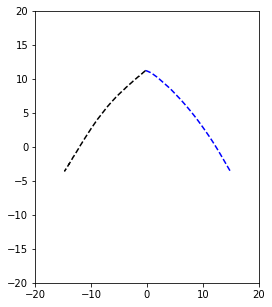

In [85]:
# PCA on learnable parameters
from sklearn.decomposition import PCA

# put bp and fa matrix together
all_params = torch.cat((all_params_FA,all_params_BP),0)

# zero mean
all_params_meanRMV = all_params.T - torch.mean(all_params, 1)

# PCA
pca = PCA(n_components=2) # keep two biggest PCs
pca.fit(all_params.cpu().numpy())
dim_reduced_params = pca.transform(all_params_meanRMV.T.cpu().numpy())

# contour map
pc1_selected_points = torch.arange(-20,21,5)
pc2_selected_points = torch.arange(-20,21,5)
loss_mat = torch.zeros((len(pc1_selected_points),len(pc2_selected_points)))
for i in range (len(pc1_selected_points)):
  for j in range (len(pc2_selected_points)):
    reconstructed_params = torch.from_numpy(pca.inverse_transform([pc1_selected_points[i],pc2_selected_points[j]])).float().to(dev)
    b1_recon, b2_recon, b3_recon, b4_recon, b5_recon, w0_recon, w1_recon, w2_recon, w3_recon, w4_recon = \
      reconstructed_params[0:50],\
      reconstructed_params[50:2*50],\
      reconstructed_params[2*50:3*50],\
      reconstructed_params[3*50:4*50],\
      reconstructed_params[4*50:5*50],\
      torch.reshape(reconstructed_params[5*50:5*50+225*50], (225, 50)),\
      torch.reshape(reconstructed_params[5*50+225*50:5*50+225*50+50**2], (50, 50)),\
      torch.reshape(reconstructed_params[5*50+225*50+50**2:5*50+225*50+2*(50**2)], (50, 50)),\
      torch.reshape(reconstructed_params[5*50+225*50+2*(50**2):5*50+225*50+3*(50**2)], (50, 50)),\
      torch.reshape(reconstructed_params[5*50+225*50+3*(50**2):5*50+225*50+4*(50**2)], (50, 50))

    _, loss_mat[i,j] = loss_val_testdata(w0_recon,w1_recon,w2_recon,w3_recon,w4_recon,b1_recon,b2_recon,b3_recon,b4_recon,b5_recon,categories_nhot,y_test_nhot,x_te_norm)

# Plot the trajectories
fig, ax = plt.subplots(1,1,figsize=(4,5))
ax.plot(dim_reduced_params[0:5999,0],dim_reduced_params[0:5999,1], color='blue', linestyle='dashed')
ax.plot(dim_reduced_params[6000:-1,0],dim_reduced_params[6000:-1,1], color='black', linestyle='dashed')
ax.set_xlim([-20, 20]);
ax.set_ylim([-20, 20]);

In [213]:
# loss function of convergence points
convergence_points = torch.tensor([[dim_reduced_params[5999,0], dim_reduced_params[5999,1]], [dim_reduced_params[-1,0], dim_reduced_params[-1,1]]])

reconstructed_params_convg = torch.zeros((2), device=dev)

loss_vals = torch.zeros((2), device=dev)

for i in range(2):
  reconstructed_params_convg = torch.from_numpy(pca.inverse_transform([convergence_points[i,0],convergence_points[i,1]])).float().to(dev)
  b1_recon, b2_recon, b3_recon, b4_recon, b5_recon, w0_recon, w1_recon, w2_recon, w3_recon, w4_recon = \
      reconstructed_params_convg[0:50],\
      reconstructed_params_convg[50:2*50],\
      reconstructed_params_convg[2*50:3*50],\
      reconstructed_params_convg[3*50:4*50],\
      reconstructed_params_convg[4*50:5*50],\
      torch.reshape(reconstructed_params_convg[5*50:5*50+225*50], (225, 50)),\
      torch.reshape(reconstructed_params_convg[5*50+225*50:5*50+225*50+50**2], (50, 50)),\
      torch.reshape(reconstructed_params_convg[5*50+225*50+50**2:5*50+225*50+2*(50**2)], (50, 50)),\
      torch.reshape(reconstructed_params_convg[5*50+225*50+2*(50**2):5*50+225*50+3*(50**2)], (50, 50)),\
      torch.reshape(reconstructed_params_convg[5*50+225*50+3*(50**2):5*50+225*50+4*(50**2)], (50, 50))

  _, loss_vals[i] =\
   loss_val_testdata(w0_recon,w1_recon,w2_recon,w3_recon,w4_recon,b1_recon,b2_recon,b3_recon,b4_recon,b5_recon,categories_nhot,y_test_nhot,x_te_norm)

accuracy:  tensor(90.4100, device='cuda:0')  | loss value:  tensor(0.4795, device='cuda:0')
accuracy:  tensor(96.9300, device='cuda:0')  | loss value:  tensor(0.1535, device='cuda:0')


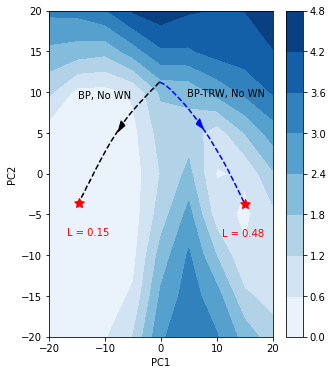

In [221]:
# Plot the trajectories
fig, ax = plt.subplots(1,1,figsize=(5,6))

# contour
X, Y = np.meshgrid(pc1_selected_points, pc2_selected_points)
cp = ax.contourf(X, Y, loss_mat.T,cmap='Blues',zorder=0)
fig.colorbar(cp)


# trajectory
ax.plot(dim_reduced_params[0:5999,0],dim_reduced_params[0:5999,1], color='blue', linestyle='dashed',zorder=1)
ax.plot(dim_reduced_params[6000:-1,0],dim_reduced_params[6000:-1,1], color='black', linestyle='dashed',zorder=1)
ax.set_xlim([-20, 20]);
ax.set_ylim([-20, 20]);

# update directions
dx_BPTRW = dim_reduced_params[502,0] - dim_reduced_params[500,0]
dy_BPTRW = dim_reduced_params[502,1] - dim_reduced_params[500,1]

dx_BP = dim_reduced_params[6382,0] - dim_reduced_params[6380,0]
dy_BP = dim_reduced_params[6382,1] - dim_reduced_params[6380,1]


ax.arrow(dim_reduced_params[500,0],dim_reduced_params[500,1], dx_BPTRW, dy_BPTRW, color='blue', width=0.3, zorder=2)
ax.arrow(dim_reduced_params[6380,0],dim_reduced_params[6380,1], dx_BP, dy_BP, color='black', width=0.3, zorder=2)

# labels
ax.text(dim_reduced_params[500,0]-2, dim_reduced_params[500,1]+3, 'BP-TRW, No WN', fontsize=10)
ax.text(dim_reduced_params[6380,0]-8, dim_reduced_params[6380,1]+3, 'BP, No WN', fontsize=10)

# loss value of convergance points
ax.scatter(dim_reduced_params[5999,0],dim_reduced_params[5999,1], zorder=3, color='red', marker=(5, 1), s=100)
ax.scatter(dim_reduced_params[-1,0],dim_reduced_params[-1,1], zorder=3, color='red', marker=(5, 1), s=100)
L1 = round(float(loss_vals[0].cpu().numpy()),2)
L2 = round(float(loss_vals[1].cpu().numpy()),2)
ax.text(dim_reduced_params[5999,0]-4,dim_reduced_params[5999,1]-4, "L = " + str(L1), fontsize=10, color='red')
ax.text(dim_reduced_params[-1,0]-2,dim_reduced_params[-1,1]-4, "L = " + str(L2), fontsize=10, color='red')

ax.set_xlabel('PC1');
ax.set_ylabel('PC2');